## Software empleado

In [ ]:
# Bibliotecas
import os, sys
import torch
import importlib
import numpy as np
import polars as pl 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Tuple, Optional, Union

In [2]:
# %load_ext autoreload
# %autoreload 2
# import visual_utils

In [3]:
sys.path.append(os.path.abspath('notebooks/'))

# Código propio
from visual_utils import * 


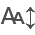

In [4]:
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

# PROBLEMA 1
# ESTIMACIÓN DE EDAD

# Carga de los resultados

In [5]:
# Carga de datos
df_AE_raw = pl.read_csv('results/AE_maxillofacial_test_results.csv')

display(df_AE_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [15]:
# 
df_AE_raw = df_AE_raw.with_columns(
    [
        # Nueva columna: absolute_error
        (pl.col('true_value')-pl.col('pred_point_value')).abs().alias('absolute_error'),
        
        # Nueva columna: squared_error
        (pl.col('true_value')-pl.col('pred_point_value')).pow(2).alias('squared_error'),
        
        # Nueva columna: interval_size
        (pl.col('pred_upper_bound') - pl.col('pred_lower_bound')).alias('pred_interval_width'),
        
        # Nueva columna: is_covered
        ((pl.col('true_value') >= pl.col('pred_lower_bound')) & 
         (pl.col('true_value') <= pl.col('pred_upper_bound'))).alias('is_covered'),
        
        # Nueva columna: interval_score
        (
            (pl.col('pred_upper_bound') - pl.col('pred_lower_bound')) +
            (2 / (1 - pl.col('confidence'))) * (pl.col('pred_lower_bound') - pl.col('true_value')).clip(0) +
            (2 / (1 - pl.col('confidence'))) * (pl.col('true_value') - pl.col('pred_upper_bound')).clip(0)
        ).alias('interval_score')
    ]
)

display(df_AE_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [16]:
#
df_AE_by_run = (
    df_AE_raw
      .group_by(['pred_model_type', 'confidence', 'iteration'])
      .agg(
        mean_absolute_error = pl.col('absolute_error').mean(),
        mean_squared_error = pl.col('squared_error').mean(),
        empirical_coverage = pl.col('is_covered').mean(),
        mean_interval_width = pl.col('pred_interval_width').mean(),
        mean_interval_score = pl.col('interval_score').mean(),
      )
)

display(df_AE_by_run)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


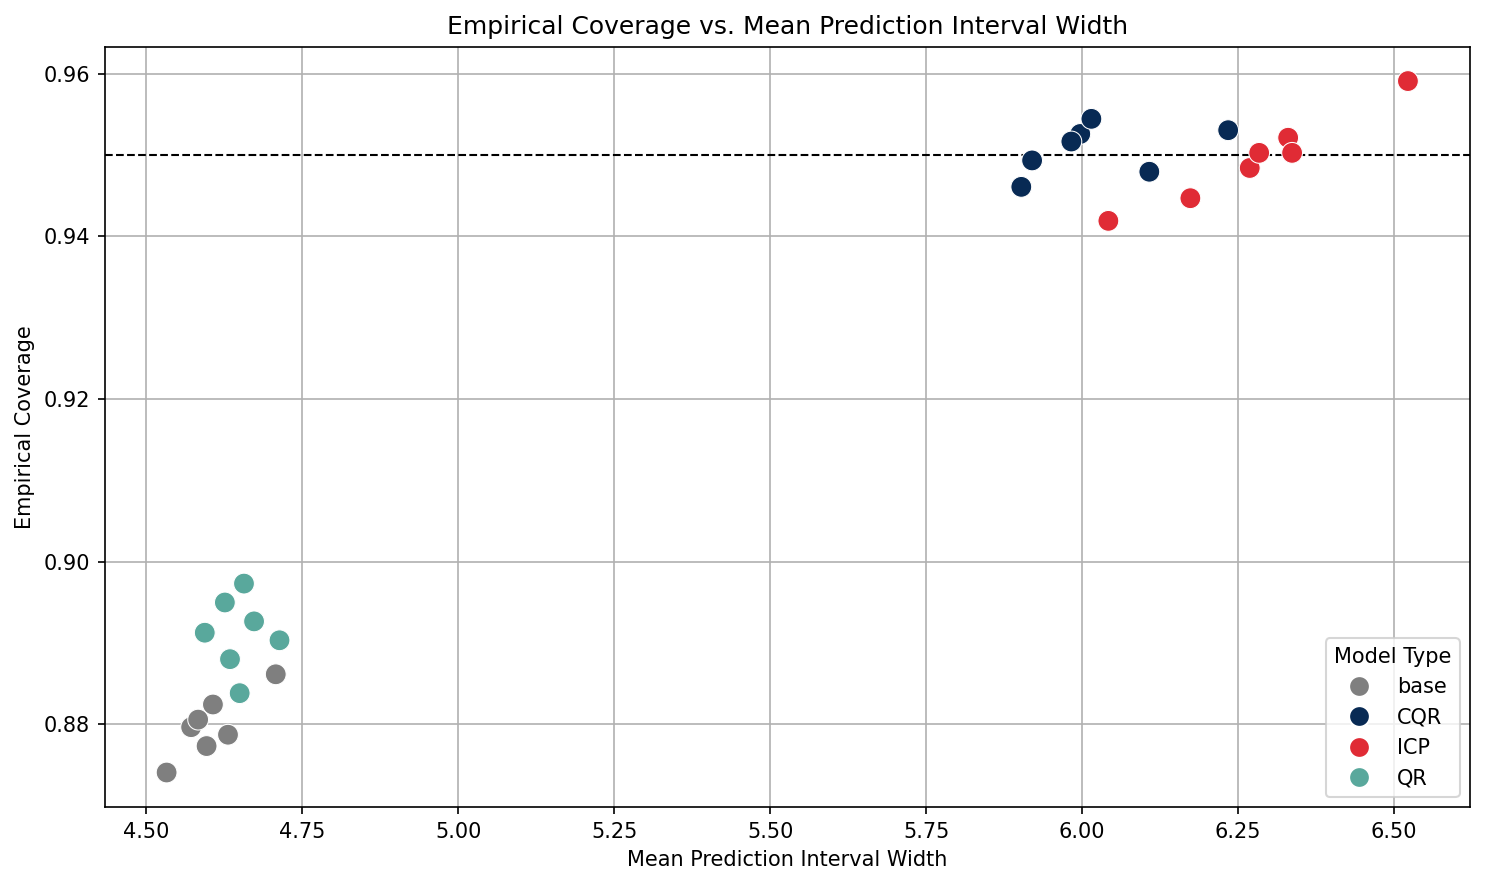

In [17]:
#
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR' : '#082a54'}
df_AE_by_run_to_plot = df_AE_by_run.with_columns(
    pl.col('pred_model_type').replace_strict(color_dict, default='black').alias('color')
)

#
plot_coverage_vs_interval_width(
    mean_pred_interval_widths = df_AE_by_run_to_plot['mean_interval_width'],
    empirical_coverages = df_AE_by_run_to_plot['empirical_coverage'],
    model_types = df_AE_by_run_to_plot['pred_model_type'],
    colors = df_AE_by_run_to_plot['color'],
    confidence_level = 0.95,
    figsize=(10,6),
    dpi=150
)

In [18]:
# 
df_AE_by_run_to_show = df_AE_by_run.with_columns(
    pl.col('mean_absolute_error').round(2).alias('mean_absolute_error'),
    pl.col('mean_squared_error').round(2).alias('mean_squared_error'),
    (pl.col('empirical_coverage') * 100).round(2).alias('empirical_coverage'),
    pl.col('mean_interval_width').round(2).alias('mean_interval_width'),
    pl.col('mean_interval_score').round(2).alias('mean_interval_score')
)

# Ordena por iteración y por tipo de predicción
df_AE_by_run_to_show = sort_by_column(df_AE_by_run_to_show, 'iteration')
custom_order = ['base', 'ICP', 'QR', 'CQR']
df_AE_by_run_to_show = sort_by_column(df_AE_by_run_to_show, 'pred_model_type', custom_order)

display(df_AE_by_run_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [19]:
#
df_AE_by_pred_model_type_to_show = (
    df_AE_by_run
      .group_by(['pred_model_type', 'confidence'])
      .agg(
        mean_mean_absolute_error = pl.col('mean_absolute_error').mean().round(2),
        mean_mean_squared_error = pl.col('mean_squared_error').mean().round(2),
        mean_empirical_coverage = (pl.col('empirical_coverage').mean() * 100).round(2),
        mean_mean_interval_width = pl.col('mean_interval_width').mean().round(2),
        mean_mean_interval_score = pl.col('mean_interval_score').mean().round(2),
      )
)

# Ordena por iteración y por tipo de predicción
custom_order = ['base', 'ICP', 'QR', 'CQR']
df_AE_by_pred_model_type_to_show = sort_by_column(df_AE_by_pred_model_type_to_show, 'pred_model_type', custom_order)

display(df_AE_by_pred_model_type_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [20]:
# Añadir columna de ranking para 'mean_interval_size' dentro de cada grupo de {pred_model_type, confidence}
df_AE_by_run = (
    df_AE_by_run
    .sort(['pred_model_type', 'confidence', 'mean_interval_width'])
    .with_columns([
        pl.col('mean_interval_score')
        .rank('dense')
        .over(['pred_model_type', 'confidence'])
        .alias('ranking_mean_interval_score')
    ])
)
    
display(df_AE_by_run)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [21]:
best_runs = (
    df_AE_by_run
    .filter(pl.col("ranking_mean_interval_score") == 1)
    .select(["pred_model_type", "confidence", "iteration"])
)

display(best_runs)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [22]:
df_best_AE_raw = df_AE_raw.join(
    best_runs,
    on=["pred_model_type", "confidence", "iteration"],
    how="inner"  # Solo conserva las coincidencias
)

display(df_best_AE_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


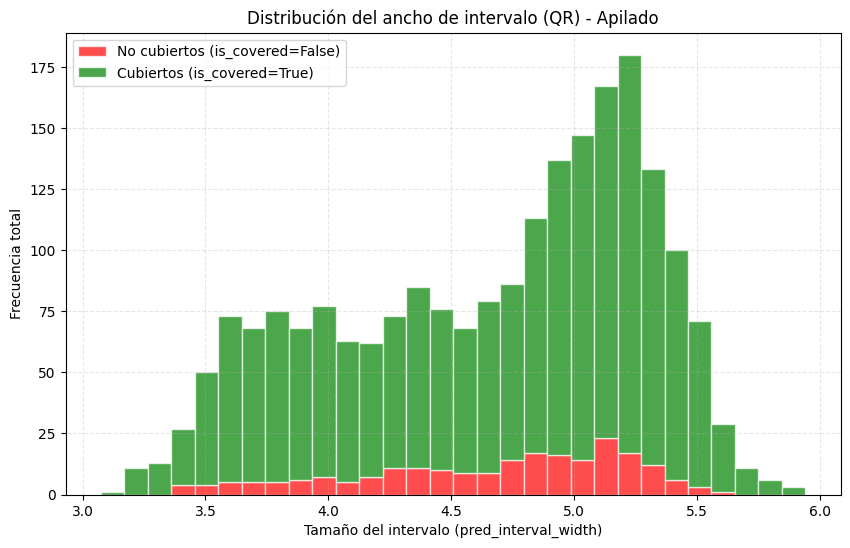

In [26]:
# Filtrar datos del modelo QR y convertir a arrays NumPy
df_QR = df_best_AE_raw.filter(pl.col("pred_model_type") == "QR")
not_covered = df_QR.filter(~pl.col("is_covered"))["pred_interval_width"].to_numpy()
covered = df_QR.filter(pl.col("is_covered"))["pred_interval_width"].to_numpy()

# Configurar bins comunes (10 bins)
min_val = min(np.min(covered), np.min(not_covered))
max_val = max(np.max(covered), np.max(not_covered))
bins = np.linspace(min_val, max_val, 31)  # 11 bordes para 10 bins

# Crear histograma apilado
plt.figure(figsize=(10, 6))
plt.hist(
    [not_covered, covered],  # ¡Orden importante: no cubiertos primero!
    bins=bins,
    label=["No cubiertos (is_covered=False)", "Cubiertos (is_covered=True)"],
    color=["red", "green"],
    alpha=0.7,
    edgecolor="white",
    stacked=True  # Key: Apilar las barras
)

# Personalización
plt.title("Distribución del ancho de intervalo (QR) - Apilado")
plt.xlabel("Tamaño del intervalo (pred_interval_width)")
plt.ylabel("Frecuencia total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

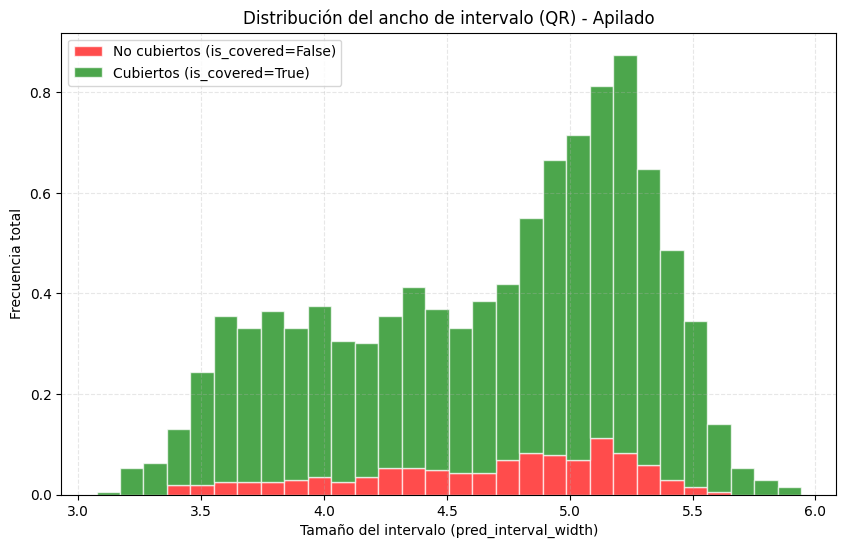

In [ ]:
# Filtrar datos del modelo QR y convertir a arrays NumPy
df_QR = df_best_AE_raw.filter(pl.col("pred_model_type") == "QR")
not_covered = df_QR.filter(~pl.col("is_covered"))["pred_interval_width"].to_numpy()
covered = df_QR.filter(pl.col("is_covered"))["pred_interval_width"].to_numpy()

# Configurar bins comunes (10 bins)
min_val = min(np.min(covered), np.min(not_covered))
max_val = max(np.max(covered), np.max(not_covered))
bins = np.linspace(min_val, max_val, 31)  # 11 bordes para 10 bins

# Crear histograma apilado
plt.figure(figsize=(10, 6))
plt.hist(
    [not_covered, covered],  # ¡Orden importante: no cubiertos primero!
    bins=bins,
    label=["No cubiertos (is_covered=False)", "Cubiertos (is_covered=True)"],
    color=["red", "green"],
    alpha=0.7,
    edgecolor="white",
    stacked=True  # Key: Apilar las barras
)

# Personalización
plt.title("Distribución del ancho de intervalo (QR) - Apilado")
plt.xlabel("Tamaño del intervalo (pred_interval_width)")
plt.ylabel("Frecuencia total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

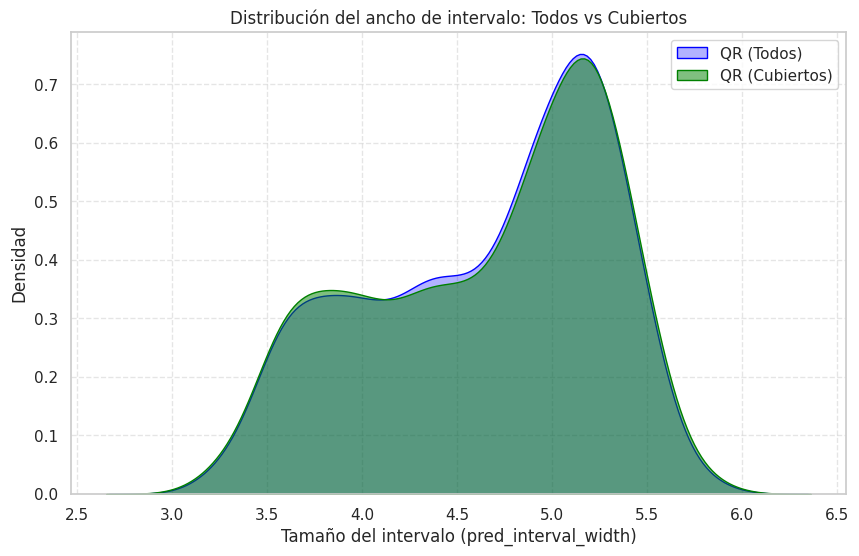

In [ ]:
selected_models = ['QR']

plt.figure(figsize=(10, 6))

for model in selected_models:
    # Datos de TODOS los intervalos (sin filtrar)
    data_all = df_best_AE_raw.filter(pl.col("pred_model_type") == model)["pred_interval_width"].to_numpy()
    
    # Datos de SOLO intervalos que cubren el valor verdadero (is_covered == True)
    data_covered = df_best_AE_raw.filter(
        (pl.col("pred_model_type") == model) & 
        (pl.col("is_covered") == True)
    )["pred_interval_width"].to_numpy()
    
    # Gráfico de densidad para todos los intervalos
    sns.kdeplot(data_all, label=f"{model} (Todos)", fill=True, alpha=0.3, color="blue")
    
    # Gráfico de densidad para intervalos que cubren el valor verdadero
    sns.kdeplot(data_covered, label=f"{model} (Cubiertos)", fill=True, alpha=0.5, color="green")

plt.title("Distribución del ancho de intervalo: Todos vs Cubiertos")
plt.xlabel("Tamaño del intervalo (pred_interval_width)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# PROBLEMA 2 
# ESTIMACIÓN DE MAYORÍA DE EDAD

## Carga de resultados

In [13]:
#
df_AMM_raw = pl.read_csv('results/AMM_maxillofacial_test_results.csv')

display(df_AMM_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [ ]:
# 
df_AMM_raw = df_AMM_raw.with_columns(
    [   
        # Nueva columna: true_positive
        ((pl.col('pred_class') == 1) & (pl.col('true_class') == 1)).alias('TP'), 
        
        # Nueva columna: true_negative 
        ((pl.col('pred_class') == 0) & (pl.col('true_class') == 0)).alias('TN'),
        
        # Nueva columna: false_negative
        ((pl.col('pred_class') == 0) & (pl.col('true_class') == 1)).alias('FN'),
        
        # Nueva columna: false_positive
        ((pl.col('pred_class') == 1) & (pl.col('true_class') == 0)).alias('FP'),
        
        # Nueva columna: is_covered
        (   ((pl.col('true_class') == 0) & (pl.col('pred_set_under_18') == 1)) |
            ((pl.col('true_class') == 1) & (pl.col('pred_set_over_18') == 1))
        ).alias('is_covered')
        
        # Nueva columna: pred_set_size
        (pl.col('pred_set_under_18')+pl.col('pred_set_over_18')).alias('pred_set_size'),
    ]
)

display(df_AMM_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [30]:
#
df_AMM_by_run = (
    df_AMM_raw
      .group_by(['pred_model_type', 'confidence', 'iteration'])
      .agg(
        accuracy = ((pl.col('TP') + pl.col('TN')) /
                    (pl.col('TP') + pl.col('TN') + pl.col('FP') + pl.col('FN'))).mean(),
        empirical_coverage = pl.col('is_covered').mean(),
        mean_set_size = pl.col('pred_set_size').mean(),
      )
)


display(df_AMM_by_run)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


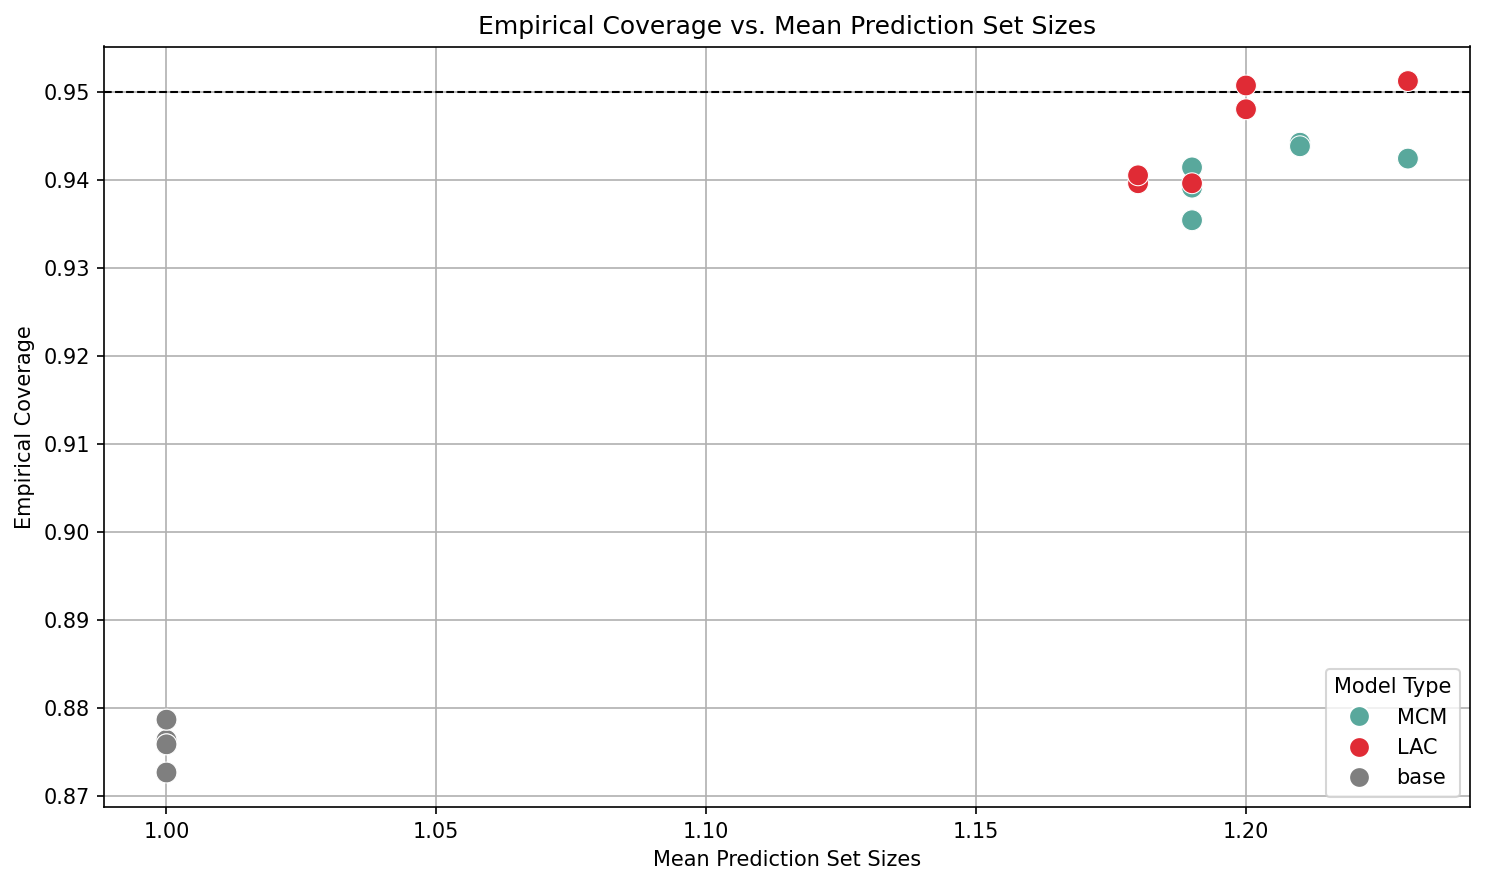

In [19]:
#
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c'}
df_AMM_by_run_to_plot = df_AMM_by_run.with_columns(
    pl.col('pred_model_type').replace_strict(color_dict, default='black').alias('color')
)

#
plot_coverage_vs_set_size(
    mean_set_sizes = df_AMM_by_run_to_plot['mean_set_size'],
    empirical_coverages = df_AMM_by_run_to_plot['empirical_coverage'],
    model_types = df_AMM_by_run_to_plot['pred_model_type'],
    colors = df_AMM_by_run_to_plot['color'],
    confidence_level = 0.95,
    figsize=(10,6),
    dpi=150
)

In [33]:
# 
df_AMM_by_run_to_show = df_AMM_by_run.with_columns(
    pl.col('accuracy').round(2).alias('accuracy'),
    (pl.col('empirical_coverage') * 100).round(2).alias('empirical_coverage'),
    pl.col('mean_set_size').round(2).alias('mean_set_size'),
)

# Ordena por iteración y tipo de predicción
df_AMM_by_run_to_show = sort_by_column(df_AMM_by_run_to_show, 'iteration')
custom_order = ['base', 'LAC', 'MCM']
df_AMM_by_run_to_show = sort_by_column(df_AMM_by_run_to_show, 'pred_model_type', custom_order)

display(df_AMM_by_run_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [54]:
# def plot_stacked_pred_set_distribution(df: pl.DataFrame):

#     # Paso 1: Crear columna categórica pred_set_type usando pl.when-then encadenado con pl.coalesce
#     pred_set_type_expr = pl.coalesce(
#         pl.when((pl.col('pred_set_under_18') == 1) & (pl.col('pred_set_over_18') == 0)).then(pl.lit('only_0')),
#         pl.when((pl.col('pred_set_under_18') == 1) & (pl.col('pred_set_over_18') == 1)).then(pl.lit('both')),
#         pl.when((pl.col('pred_set_under_18') == 0) & (pl.col('pred_set_over_18') == 1)).then(pl.lit('only_1')),
#         pl.lit('none')
#     ).alias('pred_set_type')

#     # Paso 2: Agrupar
#     grouped = df.group_by(
#         ['pred_model_type', 'confidence', 'iteration', 'pred_set_type']
#     ).agg([
#         pl.count().alias('count')
#     ])

#     # Paso 3: Pivotear
#     pivoted = grouped.pivot(
#         values='count',
#         index=['pred_model_type', 'iteration'],
#         columns='pred_set_type',
#         aggregate_function='first'
#     ).fill_null(0)

#     # Paso 4: Convertir y asegurar columnas
#     df_plot = pivoted.to_pandas()
#     df_plot['x_label'] = df_plot['pred_model_type'] + '_iter_' + df_plot['iteration'].astype(str)

#     for col in ['only_0', 'both', 'only_1']:
#         if col not in df_plot.columns:
#             df_plot[col] = 0

#     # Paso 5: Plot
#     x = np.arange(len(df_plot['x_label']))
#     only_0 = df_plot['only_0']
#     both = df_plot['both']
#     only_1 = df_plot['only_1']

#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.bar(x, only_0, label='{0}', color='#9ecae1')
#     ax.bar(x, both, bottom=only_0, label='{0,1}', color='#6baed6')
#     ax.bar(x, only_1, bottom=only_0 + both, label='{1}', color='#2171b5')

#     ax.set_xticks(x)
#     ax.set_xticklabels(df_plot['x_label'], rotation=45, ha='right')
#     ax.set_ylabel('Número de instancias')
#     ax.set_title('Distribución de conjuntos de predicción por modelo e iteración')
#     ax.legend(title='Pred set')

#     plt.tight_layout()
#     plt.show()

# PROBLEMA 3
# ESTIMACIÓN DE CLASIFICACIÓN EN SEXO Y MAYORÍA DE EDAD

## Carga de datos

In [25]:
#
df_AMSC_raw = pl.read_csv('results/AMSC_maxillofacial_test_results.csv')

display(df_AMSC_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [27]:
# 
df_AMSC_raw = df_AMSC_raw.with_columns(
    [
        # Nueva columna: is_covered
        (   ((pl.col('true_class') == 0) & (pl.col('pred_set_male_under_18') == 1)) |
            ((pl.col('true_class') == 1) & (pl.col('pred_set_male_over_18') == 1)) |
            ((pl.col('true_class') == 2) & (pl.col('pred_set_female_under_18') == 1)) |
            ((pl.col('true_class') == 3) & (pl.col('pred_set_female_over_18') == 1))
        ).alias('is_covered'),
        
        # Nueva columna: pred_set_size
        (pl.col('pred_set_male_under_18')+pl.col('pred_set_male_over_18')+
         pl.col('pred_set_female_under_18')+pl.col('pred_set_female_over_18')).alias('pred_set_size')
    ]
)

display(df_AMSC_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [34]:
#
df_AMSC_by_run = (
    df_AMSC_raw
    .group_by(['pred_model_type', 'confidence', 'iteration'])
    .agg(
        empirical_coverage = pl.col('is_covered').mean(),
        mean_set_size = pl.col('pred_set_size').mean()
    )
)

display(df_AMSC_by_run)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


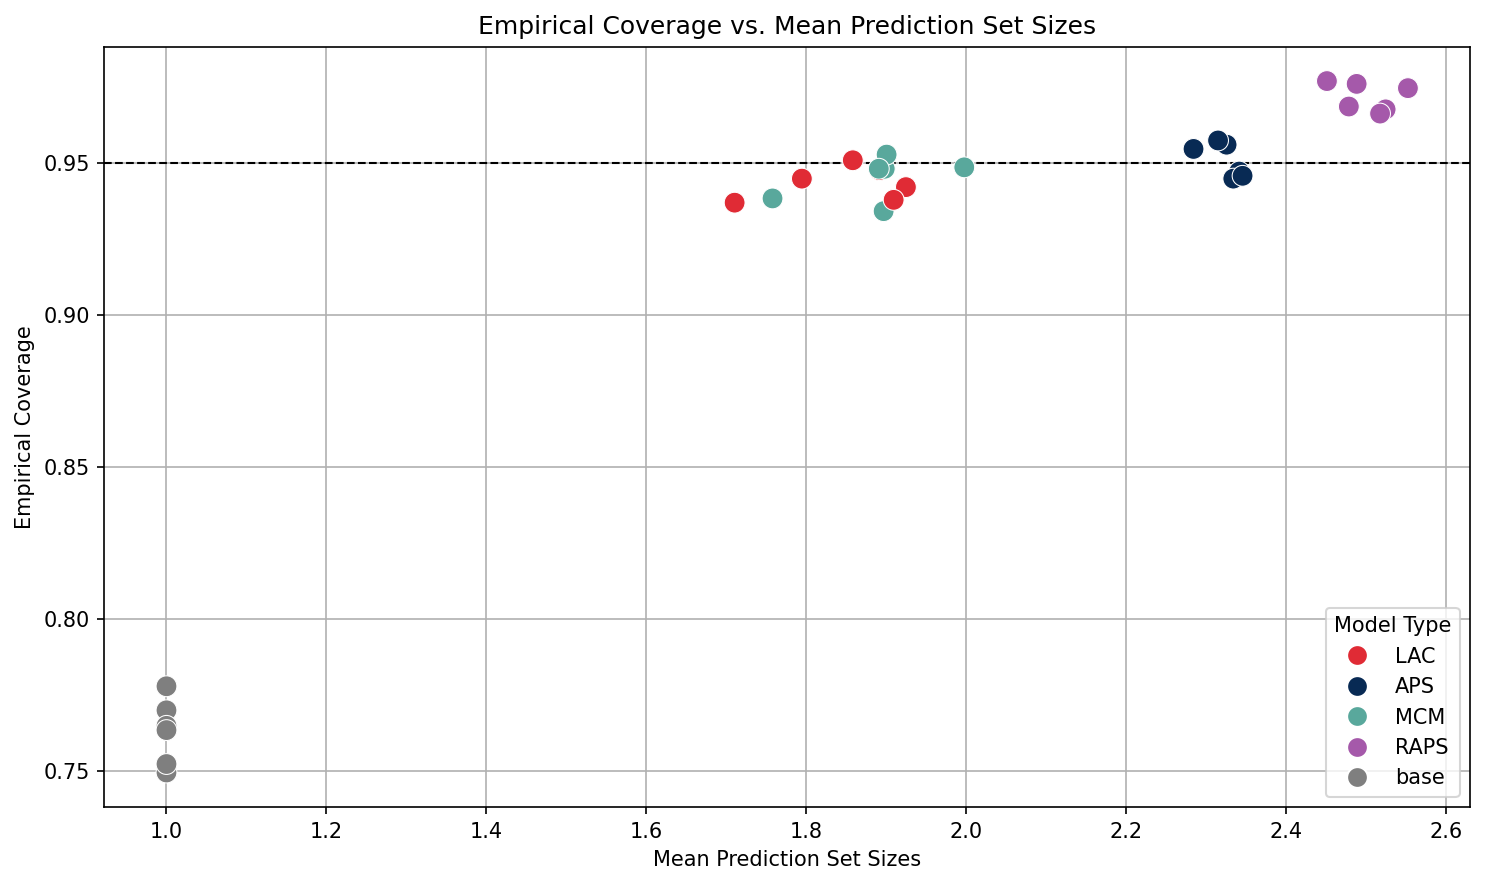

In [35]:
#
color_dict = {
    'base': '#7f7f7f', 'LAC' : '#e02b35', 'MCM': '#59a89c', 'APS' : '#082a54', 'RAPS': '#a559aa'
}
df_AMSC_by_run_to_plot = df_AMSC_by_run.with_columns(
    pl.col('pred_model_type').replace_strict(color_dict, default='black').alias('color')
)

#
plot_coverage_vs_set_size(
    mean_set_sizes = df_AMSC_by_run_to_plot['mean_set_size'],
    empirical_coverages = df_AMSC_by_run_to_plot['empirical_coverage'],
    model_types = df_AMSC_by_run_to_plot['pred_model_type'],
    colors = df_AMSC_by_run_to_plot['color'],
    confidence_level = 0.95,
    figsize=(10,6),
    dpi=150
)

In [36]:
# 
df_AMSC_by_run_to_show = df_AMM_by_run.with_columns(
    pl.col('accuracy').round(2).alias('accuracy'),
    (pl.col('empirical_coverage') * 100).round(2).alias('empirical_coverage'),
    pl.col('mean_set_size').round(2).alias('mean_set_size'),
)

# Ordena por iteración y tipo de predicción
df_AMSC_by_run_to_show = sort_by_column(df_AMSC_by_run_to_show, 'iteration')
custom_order = ['base', 'LAC', 'MCM', 'APS', 'RAPS']
df_AMSC_by_run_to_show = sort_by_column(df_AMSC_by_run_to_show, 'pred_model_type', custom_order)

display(df_AMSC_by_run_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)
